# Analyzing and Visualizing Census Rent Data

We loaded and graphed the 2014 ACS 1-year median contract rent data in [this notebook](load_geocode_rent_data.ipynb). Now, merge the data with 2010 ACS rents and 2010/2014 population data. Analyze it and then visualize it.

In [20]:
import pandas as pd, numpy as np
import statsmodels.api as sm, matplotlib.font_manager as fm
import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
# define the fonts to use for plots
family = 'Myriad Pro'
title_font = fm.FontProperties(family=family, style='normal', size=18, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=14, weight='normal', stretch='normal')

In [22]:
# load the 2014 geolocated rent data
rent14 = pd.read_csv('data/rent_latlong.csv')
rent14 = rent14.rename(columns={'geo_id2':'geo_id_14'})
rent14 = rent14[['geo_id_14', 'msa_name', 'city_state', 'median_contract_rent', 'latitude', 'longitude']]

In [23]:
# load the 2010 rent data
rent10 = pd.read_csv('data/ACS_10_1YR_B25058_metro_micro/ACS_10_1YR_B25058.csv')
rent10 = rent10.rename(columns={'GEO.id':'geo_id', 
                            'GEO.id2':'geo_id_10', 
                            'GEO.display-label':'msa_name', 
                            'HD01_VD01':'median_rent_10',
                            'HD02_VD01':'margin_error'})
rent10 = rent10[['geo_id_10', 'median_rent_10']]

## Merge the 2014 and 2010 ACS rent data

Some census statistical area names and codes have changes between 2010 and 2014. Make a dict to map from the 2014 code to the 2010 code for those that changed. Others are brand new, and yet others were dropped by 2014... just ignore those because we can't compare them unless they have data for both years.

In [24]:
# create a dict to map 2014 codes to 2010 codes for those that changed
codes_14_10 = {  #2014_code:2010_code
    14010:14060, #bloomington il
    15680:30500, #lexington park md
    16060:32060, #marion il
    17200:30100, #lebanon nh
    25840:37820, #pendleton
    26090:26100, #holland
    29200:29140, #lafayette
    38240:43860, #pinehurst
    41400:20620, #salem oh
    48260:44600, #weirton
    49220:32270, #wisconsin rapids
    31080:31100, #los angeles
    42200:42060, #santa barbara
    46520:26180, #honolulu
    48260:44600} #steubenville

# create a new column to contain 2010 code
rent14['geo_id_10'] = rent14['geo_id_14'].map(lambda x: codes_14_10[x] if x in codes_14_10.keys() else x)

In [25]:
# now merge the two datasets on 2010 code
rent = pd.merge(rent14, rent10, on='geo_id_10')
rent.head() #head() shows top 5 rows in the dataframe

,geo_id_14,msa_name,city_state,median_contract_rent,latitude,longitude,geo_id_10,median_rent_10
0,10140,"Aberdeen, WA Micro Area","Aberdeen, WA",626,46.975371,-123.815722,10140,562
1,10180,"Abilene, TX Metro Area","Abilene, TX",613,32.448736,-99.733144,10180,554
2,10300,"Adrian, MI Micro Area","Adrian, MI",556,41.897547,-84.037166,10300,537
3,10420,"Akron, OH Metro Area","Akron, OH",627,41.081445,-81.519005,10420,579
4,10500,"Albany, GA Metro Area","Albany, GA",480,31.578507,-84.155741,10500,477


In [26]:
# calculate the percentage that median rent changed between 2010 and 2014
rent['rent_change_pct'] = (rent['median_contract_rent'] / rent['median_rent_10']-1) * 100
rent.sort_values(by='rent_change_pct')[['msa_name', 'rent_change_pct']].head()

,msa_name,rent_change_pct
414,"Seneca, SC Micro Area",-14.417745
413,"Sebring, FL Metro Area",-11.992945
69,"Carson City, NV Metro Area",-9.015257
464,"Valdosta, GA Metro Area",-7.992895
442,"Talladega-Sylacauga, AL Micro Area",-7.049608


## Now load the population data

This file contains 2014 population estimates and 2010 population values from the census.

In [27]:
# load the population data
pops = pd.read_csv('data/PEP_2014_PEPANNRES/PEP_2014_PEPANNRES.csv', encoding='utf-8')
pops = pops.rename(columns={'GEO.id2':'geo_id_14', 
                              'rescen42010':'pop_10', 
                              'respop72014':'pop_est_14'})
pops = pops[['geo_id_14', 'pop_10', 'pop_est_14']]
pops.head()

,geo_id_14,pop_10,pop_est_14
0,10100,40602,42391
1,10140,72797,70818
2,10180,165252,168592
3,10220,37492,38005
4,10300,99892,99047


In [28]:
# merge the rent dataset with the population dataset
df = pd.merge(rent, pops, on='geo_id_14')
df.head()

,geo_id_14,msa_name,city_state,median_contract_rent,latitude,longitude,geo_id_10,median_rent_10,rent_change_pct,pop_10,pop_est_14
0,10140,"Aberdeen, WA Micro Area","Aberdeen, WA",626,46.975371,-123.815722,10140,562,11.387900,72797,70818
1,10180,"Abilene, TX Metro Area","Abilene, TX",613,32.448736,-99.733144,10180,554,10.649819,165252,168592
2,10300,"Adrian, MI Micro Area","Adrian, MI",556,41.897547,-84.037166,10300,537,3.538175,99892,99047
3,10420,"Akron, OH Metro Area","Akron, OH",627,41.081445,-81.519005,10420,579,8.290155,703200,703825
4,10500,"Albany, GA Metro Area","Albany, GA",480,31.578507,-84.155741,10500,477,0.628931,157308,154925


In [29]:
# calculate the percentage that population changed between 2010 and 2014
df['pop_change_pct'] = (df['pop_est_14'] / df['pop_10'] - 1) * 100
df.sort_values(by='pop_change_pct')[['msa_name', 'pop_change_pct']].head()

,msa_name,pop_change_pct
348,"Pine Bluff, AR Metro Area",-5.527738
142,"Farmington, NM Metro Area",-4.812986
377,"Roanoke Rapids, NC Micro Area",-4.371663
214,"Johnstown, PA Metro Area",-4.139088
277,"Martinsville, VA Micro Area",-3.207203


## Explore relationships in the data with some scatterplots

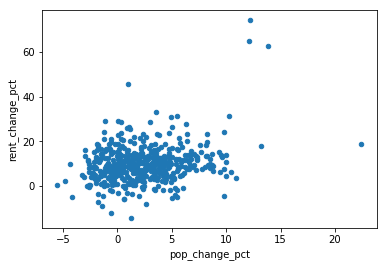

In [30]:
# percent change in rent vs percent change in population
df.plot(kind='scatter', x='pop_change_pct', y='rent_change_pct')
plt.show()

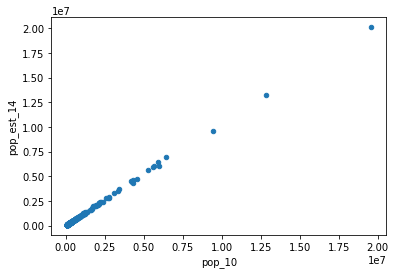

In [31]:
# 2014 population vs 2010 population
df.plot(kind='scatter', x='pop_10', y='pop_est_14')
plt.show()

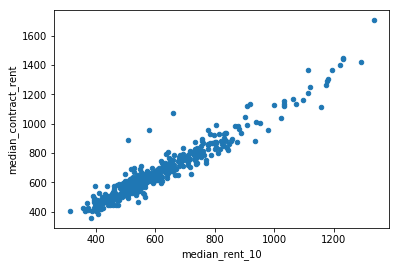

In [32]:
# 2014 median rent vs 2010 median rent
df.plot(kind='scatter', x='median_rent_10', y='median_contract_rent')
plt.show()

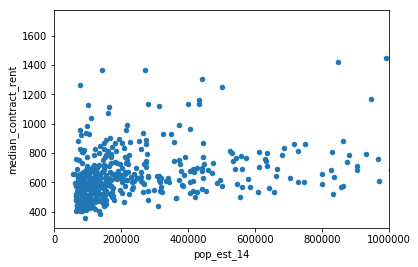

In [33]:
# 2014 median rent vs 2014 population
df.plot(kind='scatter', x='pop_est_14', y='median_contract_rent', xlim=[0, 1000000])
plt.show()

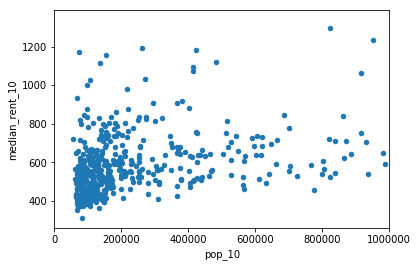

In [34]:
# 2010 median rent vs 2010 population
df.plot(kind='scatter', x='pop_10', y='median_rent_10', xlim=[0, 1000000])
plt.show()

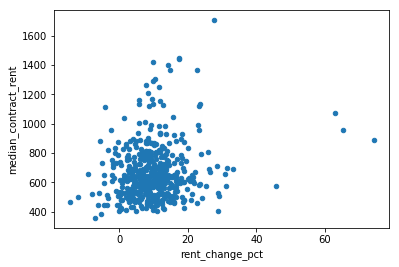

In [35]:
# 2014 median rent vs percent change in rent 2010-2014
df.plot(kind='scatter', x='rent_change_pct', y='median_contract_rent')
plt.show()

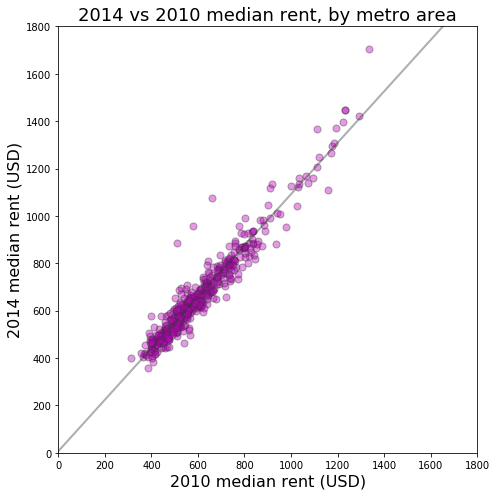

In [36]:
# plot 2014 median rent vs 2010 median rent
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
axis_min = 0
axis_max = 1800
    
# regress 2014 rent on 2010 rent
X = df['median_rent_10']
Y = df['median_contract_rent']
results = sm.OLS(Y, sm.add_constant(X)).fit()

# calculate estimated y values for regression line
X_line = X.copy()
X_line.loc[axis_min] = axis_min
X_line.loc[axis_max] = axis_max
Y_est = X_line * results.params[1] + results.params[0]

# draw points, regression line, and line of 1:1 linear relationship
#ax.plot([axis_min, axis_max], [axis_min, axis_max], 'k-', color='k', alpha=0.3, linewidth=2)
ax.plot(X_line, Y_est, c='#333333', alpha=0.4, linewidth=2)
ax.scatter(X, Y, c='m', edgecolor='#333333', alpha=0.4, s=50)

ax.set_xlim([axis_min, axis_max])
ax.set_ylim([axis_min, axis_max])

ax.set_title('2014 vs 2010 median rent, by metro area', fontproperties=title_font)
ax.set_xlabel('2010 median rent (USD)', fontproperties=label_font)
ax.set_ylabel('2014 median rent (USD)', fontproperties=label_font)

fig.tight_layout()
fig.savefig('images/scatter-rent-change-2010-2014.png', dpi=300)
plt.show()

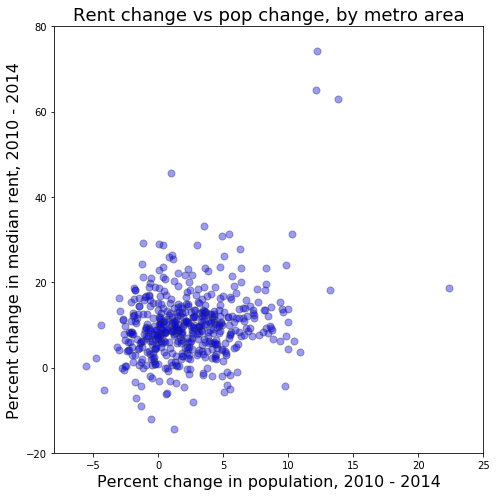

In [37]:
# plot percent change in median rent vs percent change in population, 2010-2014
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
    
# regress rent change rate on population change rate
X = df['pop_change_pct']
Y = df['rent_change_pct']
results = sm.OLS(Y, sm.add_constant(X)).fit()

# calculate estimated y values for regression line
X_line = X.copy()
X_line.loc[-10] = -10
X_line.loc[30] = 30
Y_est = X_line * results.params[1] + results.params[0]

# draw points, regression line
#ax.plot(X_line, Y_est, c='#333333', alpha=0.4, linewidth=2)
ax.scatter(X, Y, c='b', edgecolor='#333333', alpha=0.4, s=50)

ax.set_xlim([-8, 25])
ax.set_ylim([-20, 80])

ax.set_title('Rent change vs pop change, by metro area', fontproperties=title_font)
ax.set_xlabel('Percent change in population, 2010 - 2014', fontproperties=label_font)
ax.set_ylabel('Percent change in median rent, 2010 - 2014', fontproperties=label_font)

fig.tight_layout()
fig.savefig('images/scatter-rent-pop-change-2010-14.png', dpi=300)
plt.show()

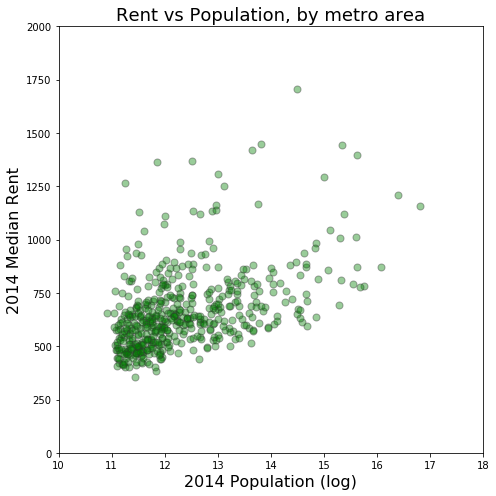

In [38]:
# plot 2014 median rent vs 2014 population
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
    
# regress rent on population
X = np.log(df['pop_est_14'])
Y = df['median_contract_rent']
results = sm.OLS(Y, sm.add_constant(X)).fit()

# calculate estimated y values for regression line
X_line = X.copy()
X_line.loc[0] = 0
X_line.loc[20] = 20
Y_est = X_line * results.params[1] + results.params[0]

# draw points, regression line
#ax.plot(X_line, Y_est, c='#333333', alpha=0.4, linewidth=2)
ax.scatter(X, Y, c='g', edgecolor='#333333', alpha=0.4, s=50)

ax.set_xlim([10, 18])
ax.set_ylim([0, 2000])

ax.set_title('Rent vs Population, by metro area', fontproperties=title_font)
ax.set_xlabel('2014 Population (log)', fontproperties=label_font)
ax.set_ylabel('2014 Median Rent', fontproperties=label_font)

fig.tight_layout()
fig.savefig('images/scatter-rent-pop-log-2010-14.png', dpi=300)
plt.show()